In [27]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import math

from SDAN.model import pipeline
from SDAN.preprocess import qc
from SDAN.train import test_model
from SDAN.utils import compute_leiden, s2name
from SDAN.args import parse_args
from SDAN.utils import plot_contingency, plot_confusion, plot_s

import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

np.random.seed(888)
torch.manual_seed(888)

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(figsize=(8, 6), dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.9.3 pandas==1.5.2 scikit-learn==1.2.0 statsmodels==0.13.5 python-igraph==0.10.3 pynndescent==0.5.8


Set parameters

In [2]:
import argparse


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='Disables CUDA training.')
    parser.add_argument('--n_top_genes', type=int, default=1000,
                        help='Number of DE genes to use for each type.')
    parser.add_argument('--n_comp', type=int, default=40,
                        help='Number of components.')
    parser.add_argument('--epochs', type=int, default=50000,
                        help='Number of epochs to train.')
    parser.add_argument('--lr', type=float, default=1e-4,
                        help='Initial learning rate.')
    parser.add_argument('--hidden1', type=int, default=64,
                        help='Number of first hidden units.')
    parser.add_argument('--hidden2', type=int, default=64,
                        help='Number of second hidden units.')
    parser.add_argument('--graph_weight', type=float, default=1,
                        help='Weight of the graph loss.')
    parser.add_argument('--mc_weight', type=float, default=1,
                        help='Weight of the minCUT loss.')
    parser.add_argument('--o_weight', type=float, default=1,
                        help='Weight of the orthogonality loss')
    parser.add_argument('--start_patience', type=int, default=3000,
                        help='Number of patience for early stopping.')
    parser.add_argument('--epochs_min', type=int, default=10000,
                        help='Minimum number of epochs to train.')
    args = parser.parse_args([])
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    return args

args = parse_args()

Set the directions of training data and test data.

In [3]:
d = "./Zheng_2017/"
train_dir = f'{d}sc9_train.h5ad'
test_dir = f'{d}sc9_test.h5ad'

Set the two or several cell types to classification. We use ``cell_type_str`` for identify file name for different combination of cell types.

In [4]:
cell_type_list = ["cd4_t_helper", "naive_t"]
cell_type_str = "-".join(cell_type_list)

In [5]:
os.makedirs(f'{d}figures/', exist_ok=True)
os.makedirs(f'{d}output/', exist_ok=True)

Load training data and test data.

In [6]:
train_data = sc.read(train_dir)
test_data = sc.read(test_dir)

In [7]:
train_data

AnnData object with n_obs × n_vars = 42457 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [8]:
test_data

AnnData object with n_obs × n_vars = 42458 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Preprocess data.

In [9]:
qc(train_data)
qc(test_data)

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 42458 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'log1p'

In [10]:
train_data.obs.cell_type.value_counts()

naive_cytotoxic    6009
cd4_t_helper       5576
naive_t            5217
regulatory_t       5135
cytotoxic_t        5112
memory_t           5098
b_cells            4995
cd56_nk            4033
cd14_monocytes     1282
Name: cell_type, dtype: int64

In [11]:
test_data.obs.cell_type.value_counts()

naive_cytotoxic    5900
cd4_t_helper       5601
naive_t            5243
memory_t           5106
regulatory_t       5084
cytotoxic_t        5081
b_cells            4928
cd56_nk            4222
cd14_monocytes     1293
Name: cell_type, dtype: int64

Filter training data and test data by cell type, so that the data contains only the cells with given cell types to classify.

In [12]:
train_data = train_data[train_data.obs.cell_type.isin(cell_type_list),:]
test_data = test_data[test_data.obs.cell_type.isin(cell_type_list),:]

In [13]:
train_data

View of AnnData object with n_obs × n_vars = 10793 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'log1p'

In [14]:
test_data

View of AnnData object with n_obs × n_vars = 10844 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'log1p'

We split 10% of the training data to be validation data for the training process.

In [15]:
val_cell_id = train_data.obs.index[np.random.choice(len(train_data), math.floor(0.1*len(train_data)), replace = False)]
val_data = train_data[val_cell_id]
val_data

View of AnnData object with n_obs × n_vars = 1079 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'log1p'

In [16]:
train_cell_id = [index for index in train_data.obs.index if index not in val_cell_id]
train_data = train_data[train_cell_id]

In [17]:
train_data

View of AnnData object with n_obs × n_vars = 9714 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'log1p'

We input the data into our SDAN pipeline.

The number of DE genes for cd4_t_helper: 1677
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/zxlin/opt/anaconda3/envs/gene_embedding/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


The number of DE genes for naive_t: 181
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
The number of DE genes: 1181


/Users/zxlin/opt/anaconda3/envs/gene_embedding/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


The proportion of non-isolated genes: 0.88
The proportion of non-isolated genes: 0.88
The proportion of non-isolated genes: 0.88
Epoch: 000, Train Loss: 1.3767, Train AUC: 0.6892, Val Loss: 1.0051, Val AUC: 0.6648, Test Loss: 0.9992, Test AUC: 0.6822
Epoch: 1000, Train Loss: 0.6805, Train AUC: 0.8467, Val Loss: 0.6782, Val AUC: 0.8426, Test Loss: 0.6798, Test AUC: 0.8328
Epoch: 2000, Train Loss: 0.5876, Train AUC: 0.8604, Val Loss: 0.5876, Val AUC: 0.8474, Test Loss: 0.5957, Test AUC: 0.8325
Epoch: 3000, Train Loss: 0.4718, Train AUC: 0.8908, Val Loss: 0.5100, Val AUC: 0.8630, Test Loss: 0.5319, Test AUC: 0.8485
Epoch: 4000, Train Loss: 0.3422, Train AUC: 0.9048, Val Loss: 0.3830, Val AUC: 0.8730, Test Loss: 0.4049, Test AUC: 0.8572
Epoch: 5000, Train Loss: 0.1534, Train AUC: 0.9117, Val Loss: 0.2094, Val AUC: 0.8704, Test Loss: 0.2211, Test AUC: 0.8606
Epoch: 6000, Train Loss: -0.0331, Train AUC: 0.9185, Val Loss: 0.0441, Val AUC: 0.8668, Test Loss: 0.0493, Test AUC: 0.8615
Epoch: 700

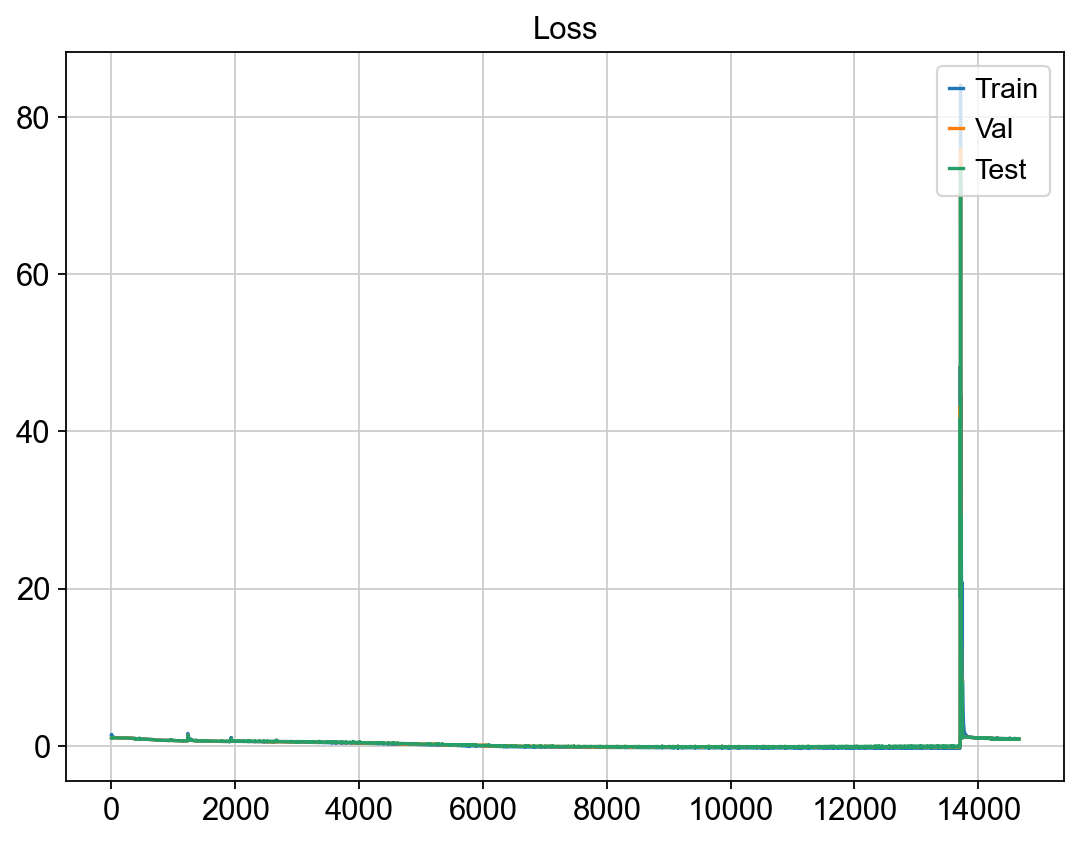

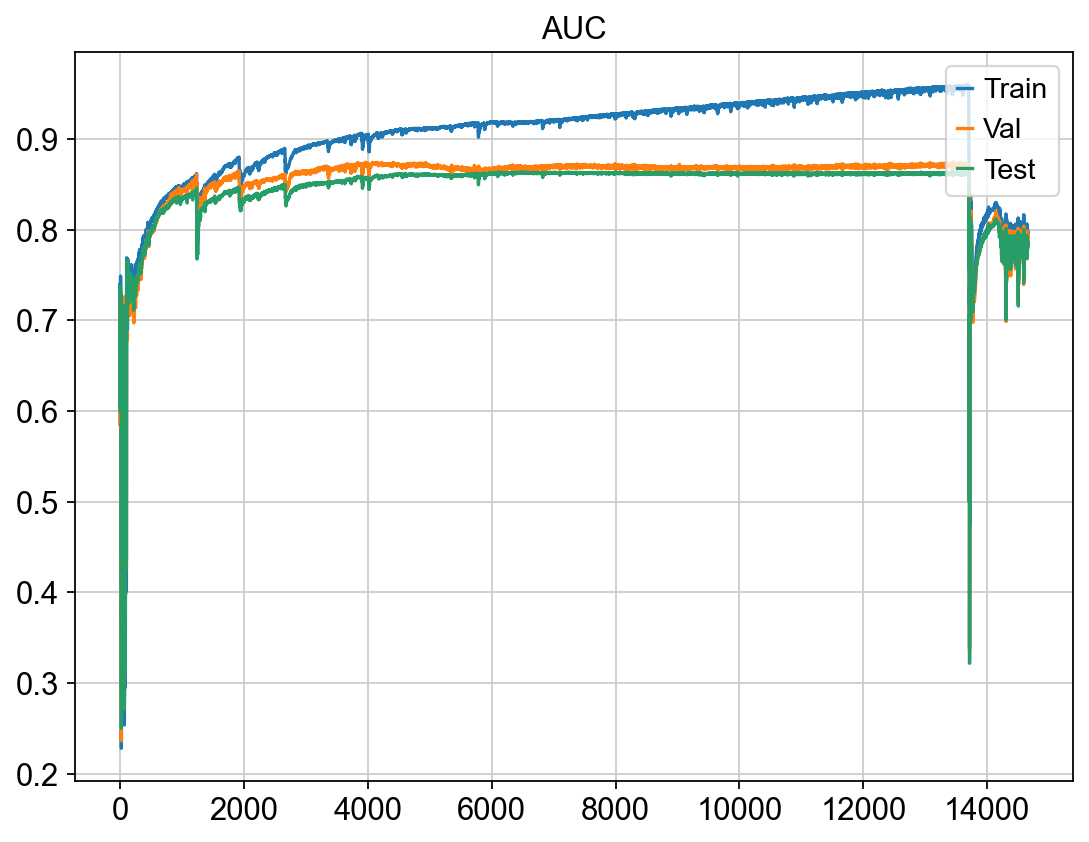

In [18]:
[train_GNN, val_GNN, test_GNN], [train_labels, val_labels, test_labels], cell_type_list, gene_list = \
    pipeline([train_data, val_data, test_data], args, d, cell_type_str)

Import the saved models and assignment matrix.

In [19]:
model_dir = f'{d}output/model_{cell_type_str}.pth'
model = torch.load(model_dir)
train_s_dir = f'{d}output/train_s_{cell_type_str}.npy'
train_s = torch.tensor(np.load(train_s_dir))

Compute the validation and test AUC.

In [20]:
test_data_reduced = test_GNN.x.t() @ train_s
val_data_reduced = val_GNN.x.t() @ train_s
test_score, _, test_auc = test_model(model, test_data_reduced, test_labels)
val_score, _, val_auc = test_model(model, val_data_reduced, val_labels)

print(f'Val AUC: {val_auc:.4f}, Test AUC: {test_auc:.4f}')

Val AUC: 0.8691, Test AUC: 0.8609


Apply the Leiden algorithm to the data after dimension reduction for unsupervised clustering.

In [21]:
test_reduced = compute_leiden(test_data_reduced.detach().numpy(), test_data, n_neighbors=20, resolution=1)

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [22]:
sc.tl.tsne(test_reduced, n_pcs=0)

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:31)


In [23]:
s2name(train_s, gene_list, cell_type_str, d)

Plot the contingency matrix.

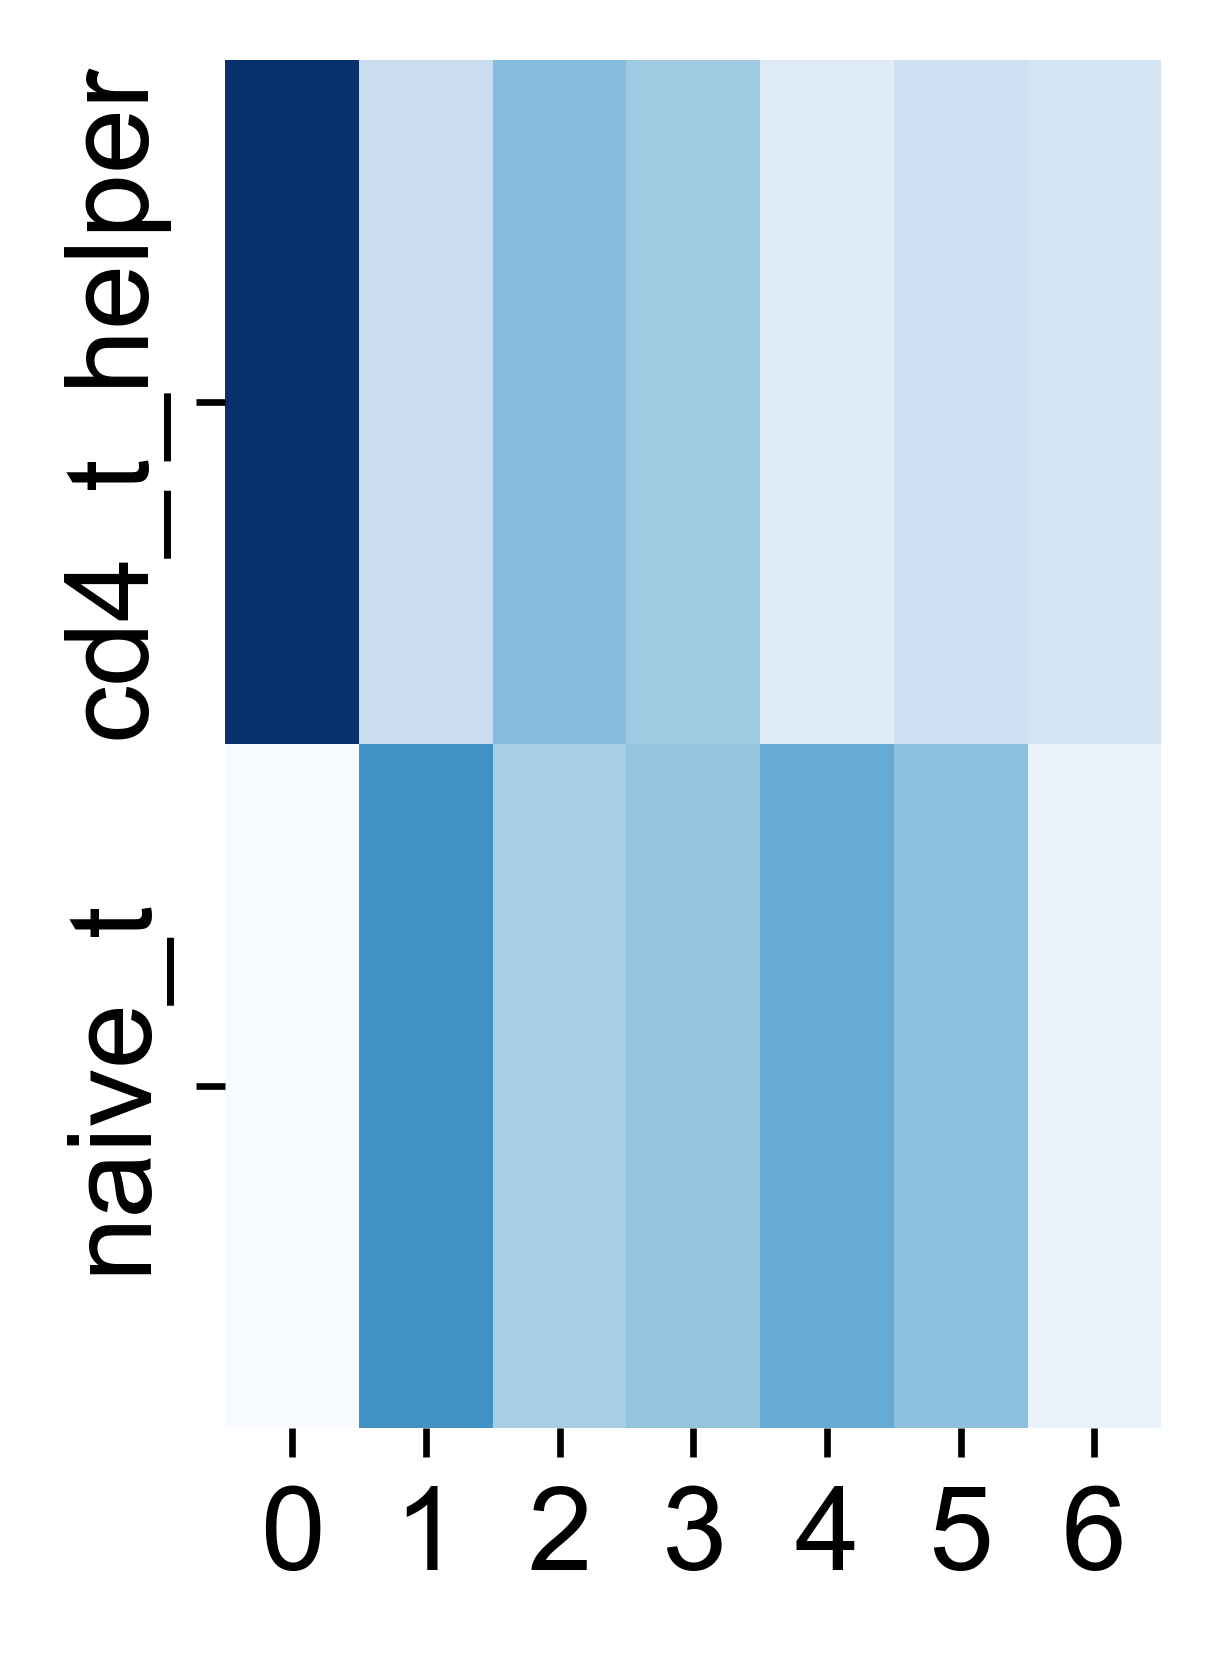

In [29]:
plt.figure(figsize=(2, 3), dpi=300)
plot_contingency(test_reduced, cell_type_list, cell_type_str, d)

Plot the confusion matrix.

<Figure size 640x480 with 0 Axes>

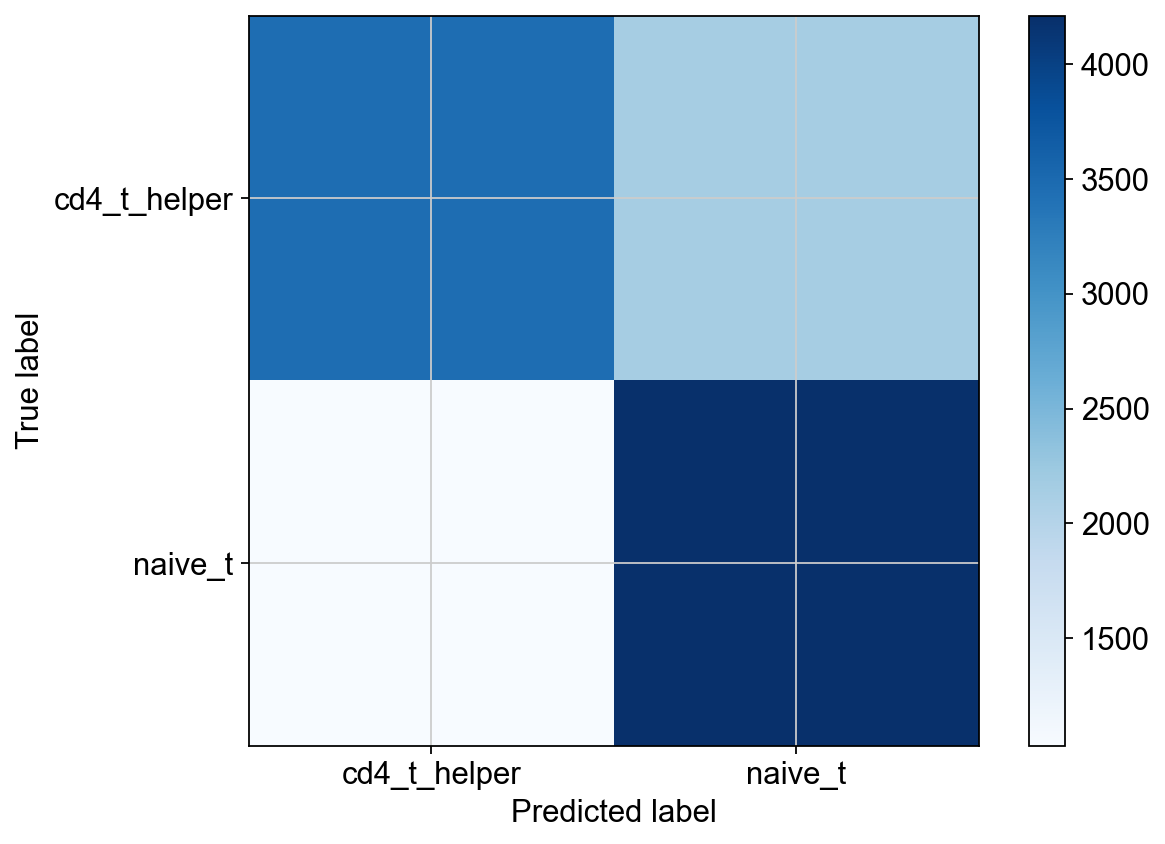

In [30]:
plt.figure()
plot_confusion(test_reduced, cell_type_str, d)

Plot the TSNE.

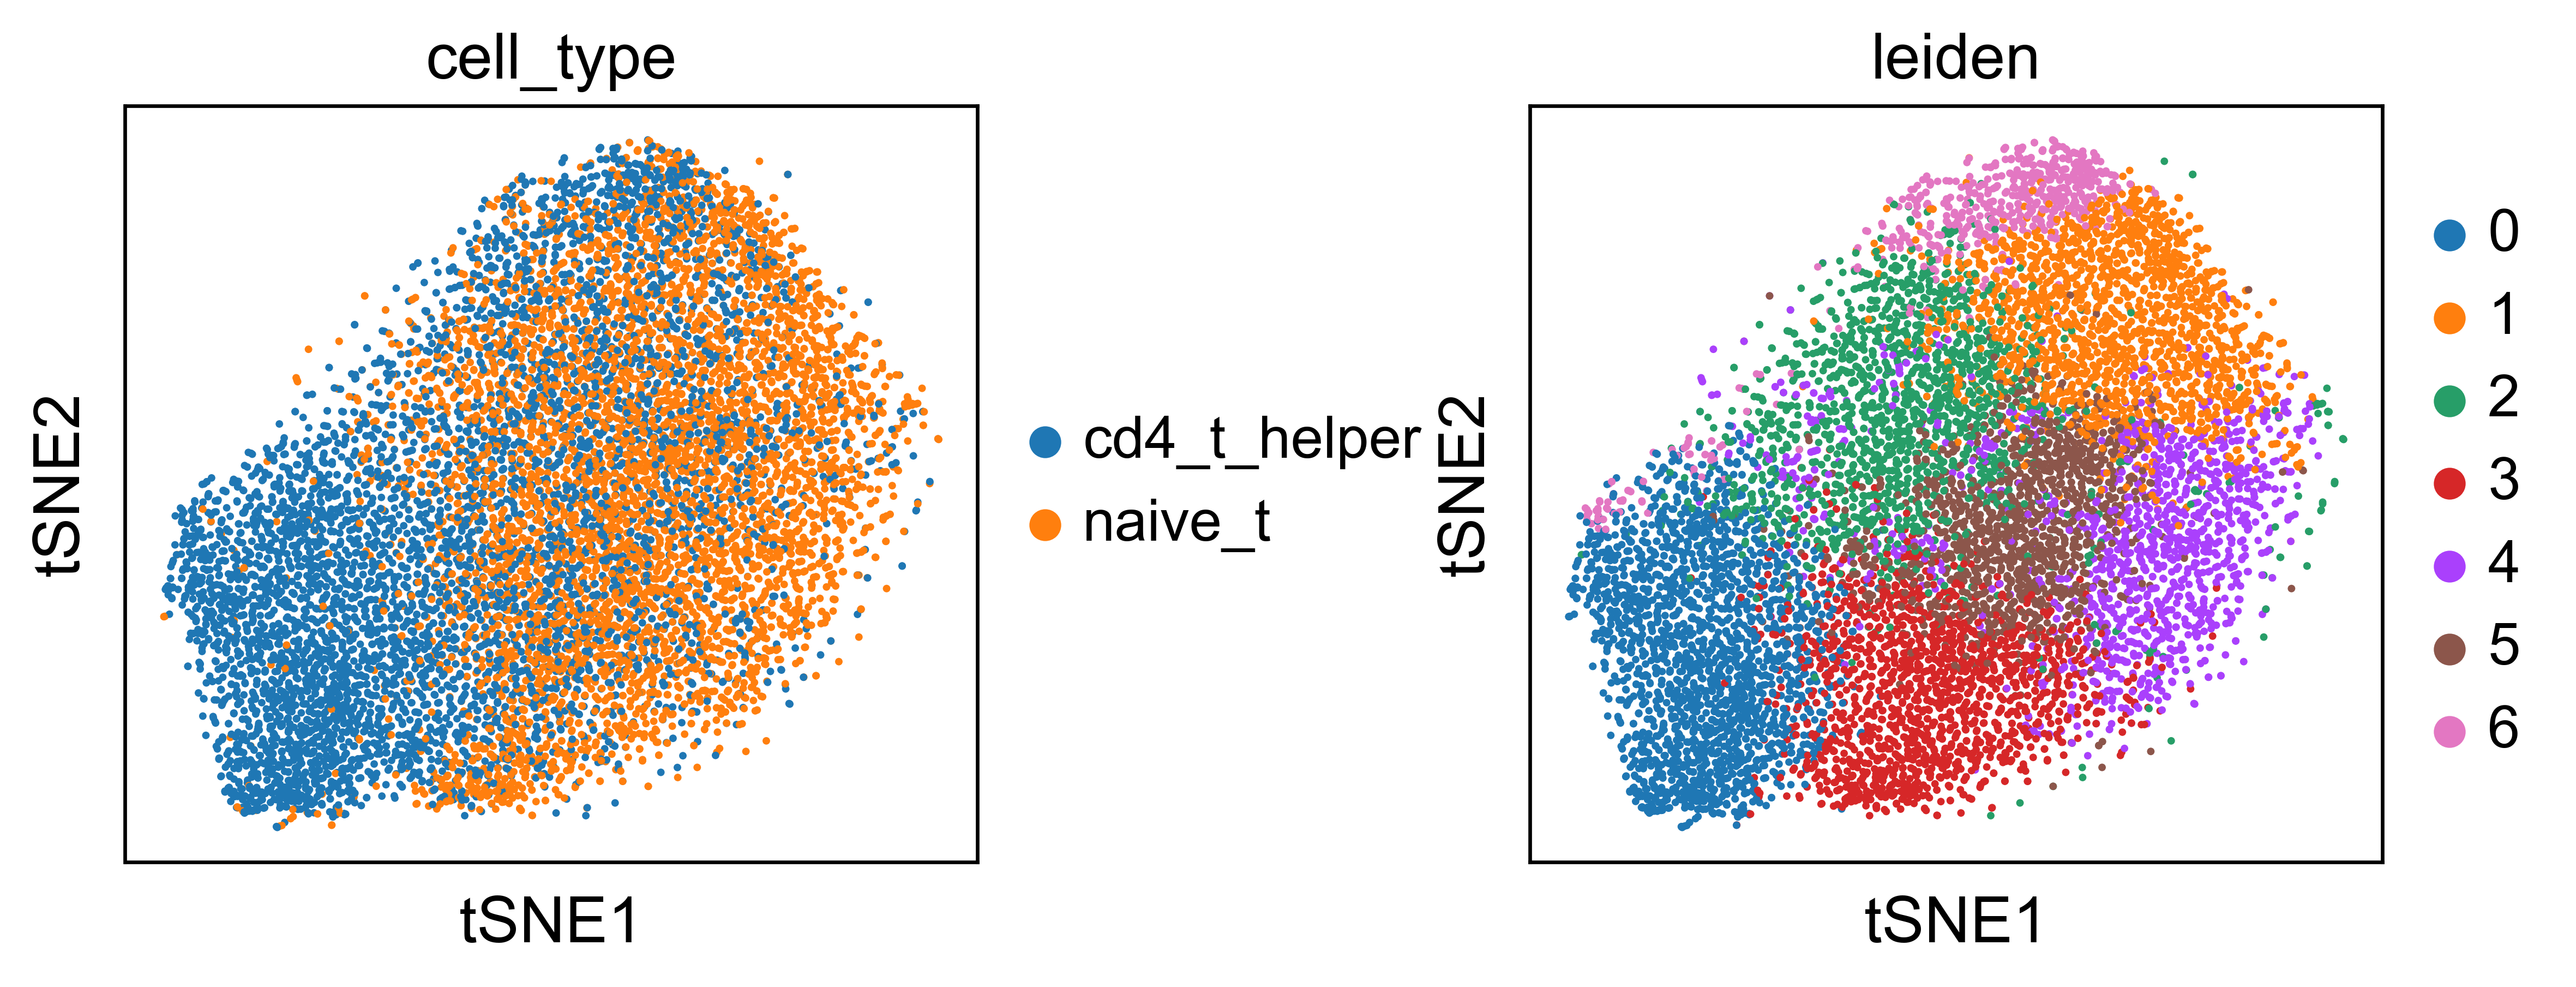

In [31]:
sc.settings.set_figure_params(figsize=(3, 3), dpi=300)
sc.pl.tsne(test_reduced, color=["cell_type", "leiden"], title=['cell_type', 'leiden'], return_fig=True, wspace=0.5)
plt.savefig(f'{d}figures/tsne_{cell_type_str}.pdf')

Plot the heatmap of the assignment matrx.

<Figure size 900x900 with 0 Axes>

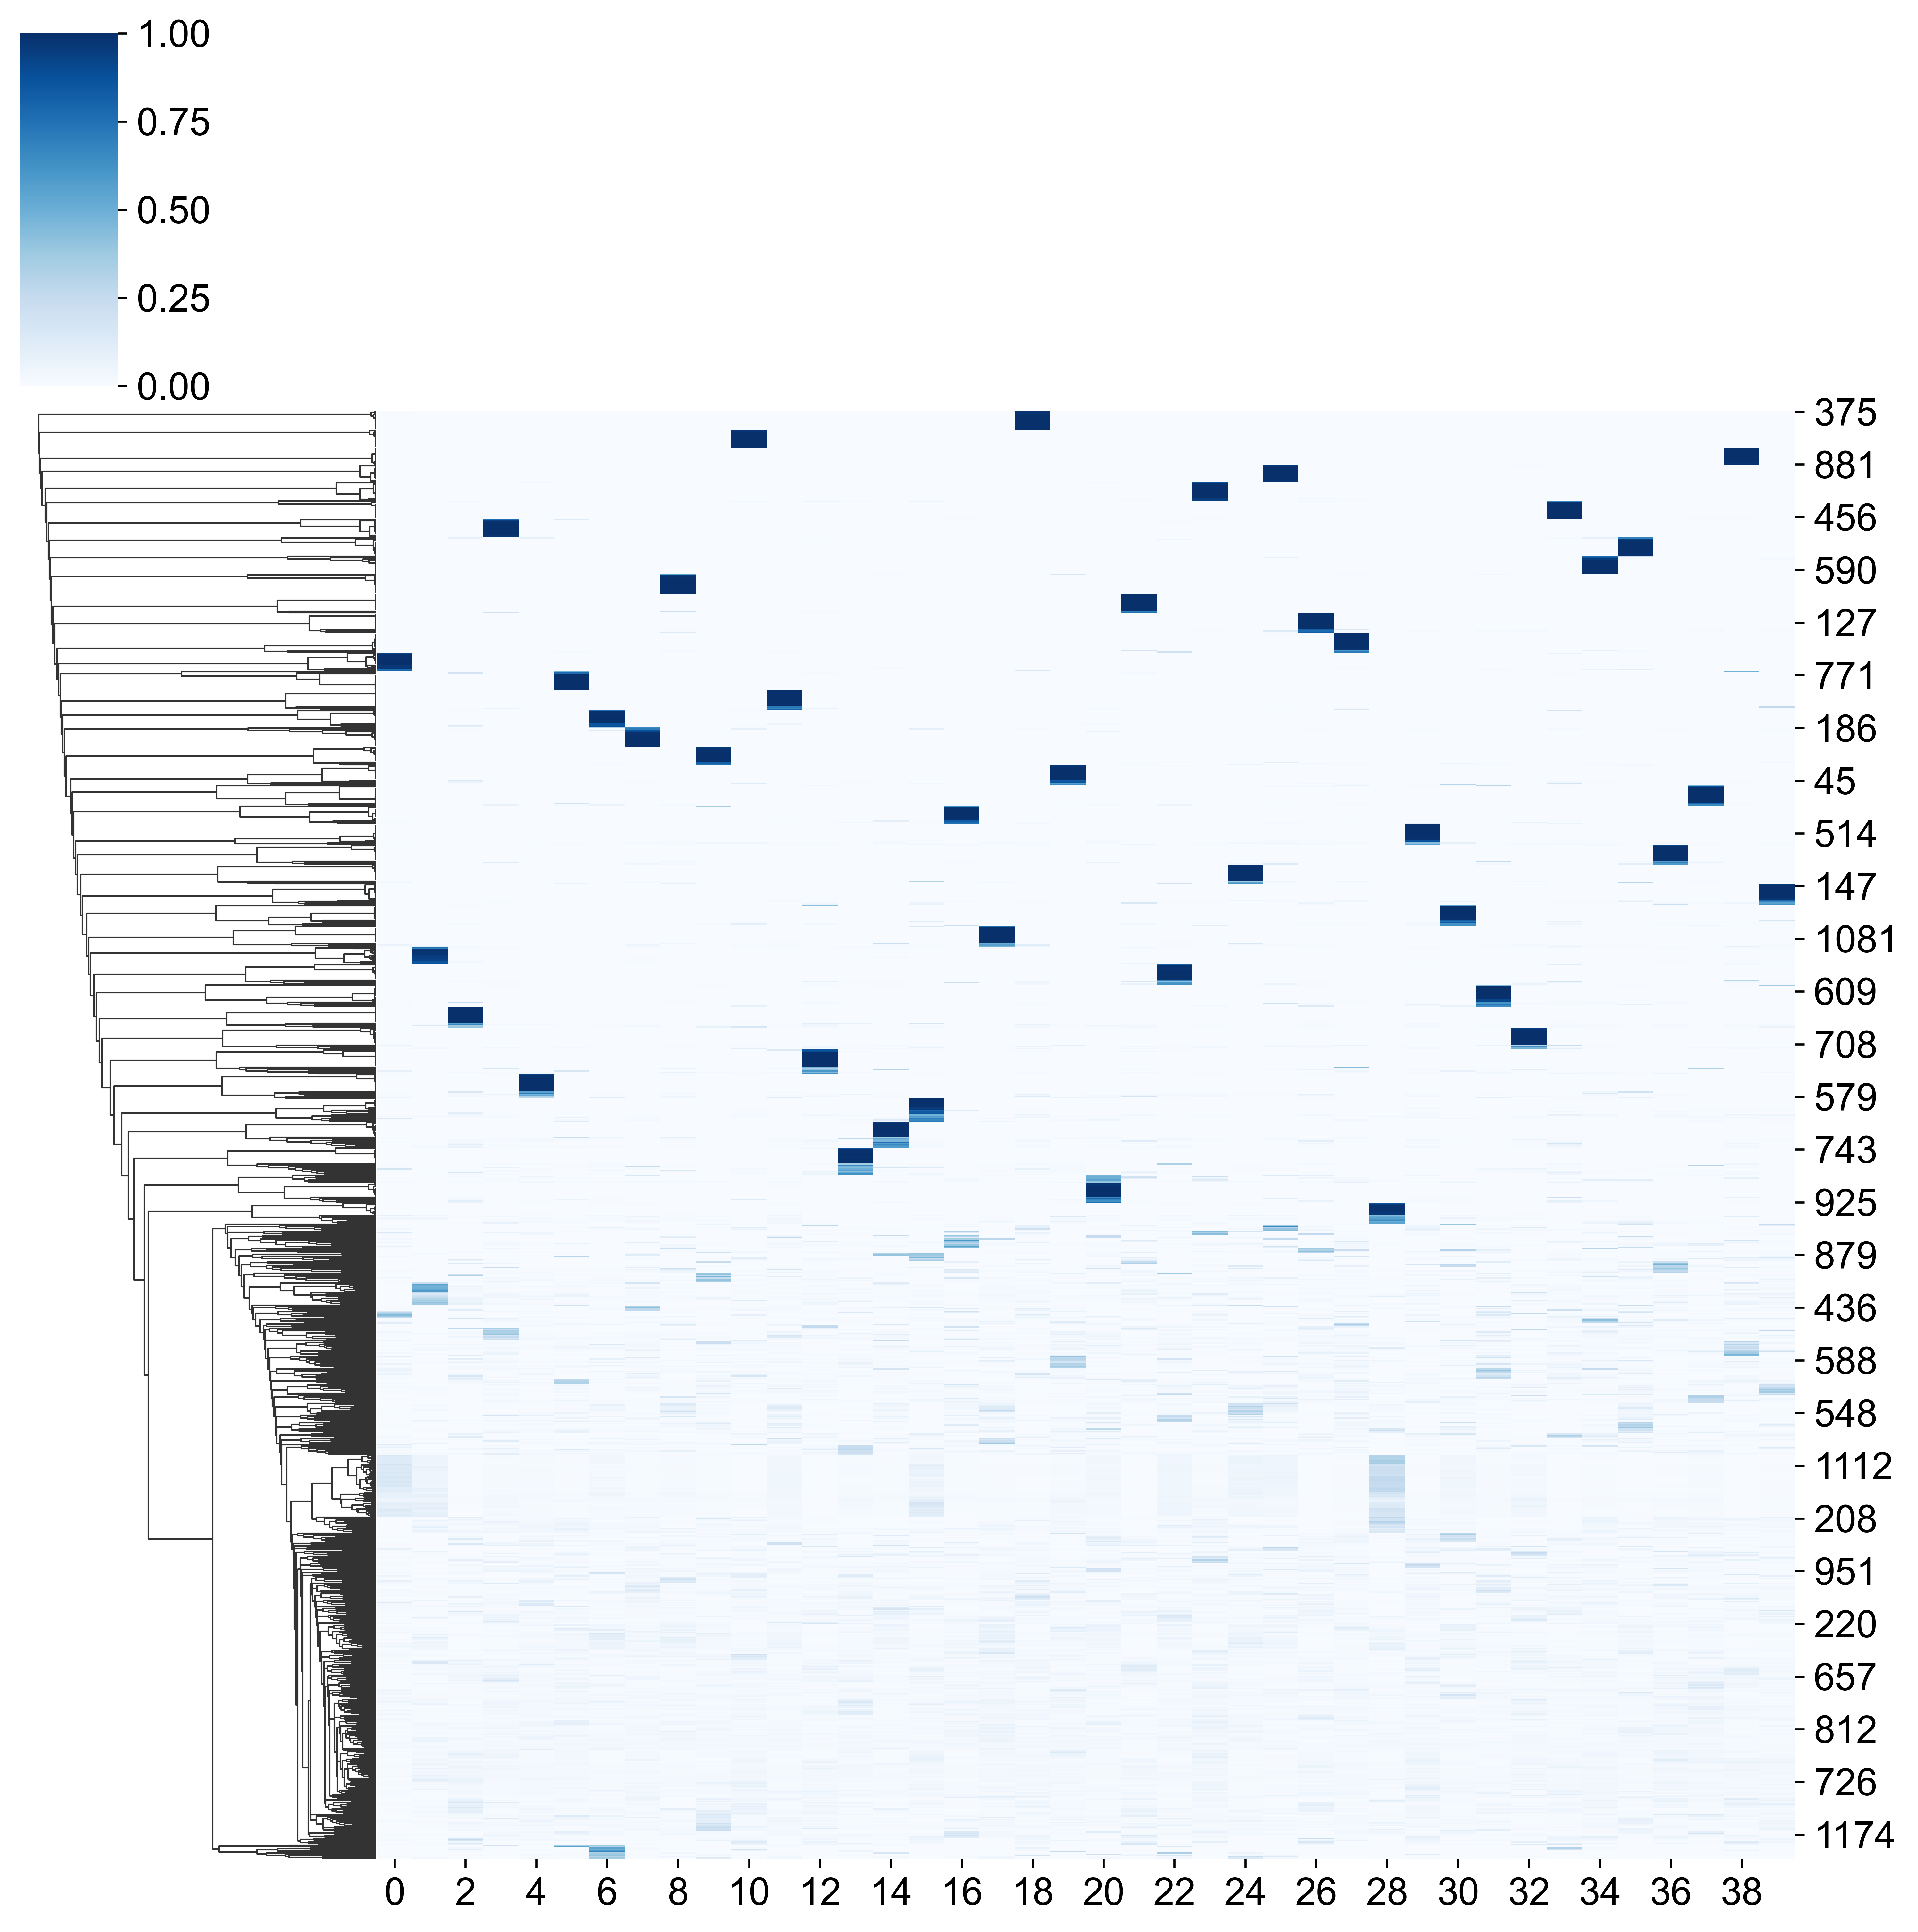

In [32]:
plt.figure(figsize=(3, 3), dpi=300)
plot_s(train_s, cell_type_str, d)

Print the names of genes in each component by the assignment matrix.

In [33]:
pd.read_csv(f'{d}/output/name_s_{cell_type_str}.txt', sep='\t', header=None)

,0
0,"CD2,DUSP1,SPOCK2,CD151,CD82,TMEM208,VPS4B,SERI..."
1,"ATPAF1,MRPL9,MRPL47,GLUD1,EXOSC1,MRPL17,MRPL21..."
2,"KIAA1324,RP5-1073O3.7,BTD,WDR53,GPRIN3,AAED1,R..."
3,"MAN1A2,CLDND1,TMA16,STX11,MID1IP1,RABL6,LOH12C..."
4,"CCDC23,WDR54,ATP5G3,KIAA1430,TOR2A,NUDT22,PRKC..."
5,"CFLAR,CISH,RNF7,TNFSF10,GATA3,CASP4,WSB2,GCHFR..."
6,"SYTL1,SRA1,CD164,PDLIM2,ZFP36L1,CLN3-1,ACD,SRR..."
7,"MAP7D1,RHOC,ABHD14A,RHBDD2,TIMM17B,GLIPR2,SPRY..."
8,"LMCD1,ACYP1,RP5-1028K7.2,FAM104A,AK5,TRABD2A,A..."
9,"ADPRHL2,SH2D2A,ANKRD39,COPS8,LRRFIP1,SLBP,INPP..."
